In [9]:
import matplotlib.pyplot as plt

import numpy as np
from scipy.fft import fft, fftfreq
from statsmodels.tsa.stattools import pacf_burg, levinson_durbin_pacf, acf

from neurodsp.spectral import compute_spectrum
from neurodsp.utils import normalize_sig

from timescales.conversions import convert_knee
from timescales.sim import sim_branching

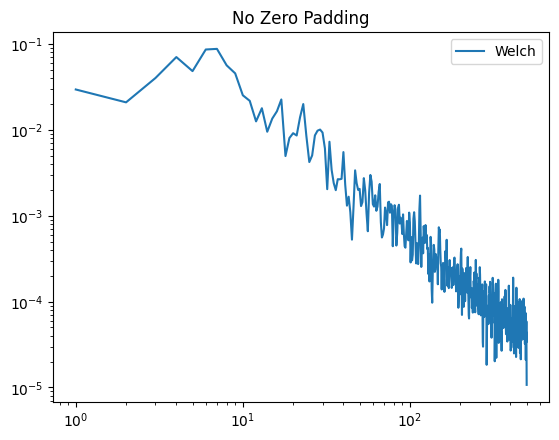

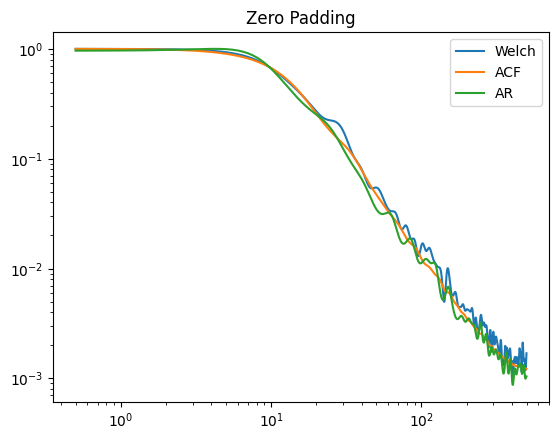

In [14]:
# Simulate
np.random.seed(2)

fs = 1000
tau = convert_knee(10)
X = normalize_sig(sim_branching(5, fs, tau, 1000), 0, 1)

# Standard Welch's
f, p = compute_spectrum(X, fs)
plt.figure(0)
plt.title("No Zero Padding")
plt.loglog(f[1:], p[1:], label="Welch")
plt.legend();

nfft = 2000
freqs = fftfreq(nfft, 1/fs)[:nfft//2]

# Compute pacf, acf, and ar:
#
#   A different number of lags is for AR and ACF
#   because the AR coefs reaches 0 much faster then ACF coefs  
#
#   There is likely some criteria (e.g. lags until zero),
#   heuristic, or math that can equate AR and ACF since they
#   are linked in the Levinson-Durbin algorithm.

nlags = 50
pacf, sigma = pacf_burg(X, nlags, demean=False)
ar, _ = levinson_durbin_pacf(pacf)

nlags = 50
pacf, sigma = pacf_burg(X, nlags, demean=False)
_, acf_ld = levinson_durbin_pacf(pacf) # <- AR and ACF computed during the same LD
                                        #   recursions see function source for more info

# PSD from zero-padded AR
ar_pad = np.zeros(nfft)
ar_pad[0] = 1.
ar_pad[1:len(ar)+1] = -ar

psd_ar_pad = 1 / np.abs(fft(ar_pad, nfft))**2.
psd_ar_pad = psd_ar_pad[:len(psd_ar_pad)//2]


# PSD from zero-padded ACF
lags = np.arange(nfft)
acf_pad = np.zeros(nfft)
acf_pad[:len(acf_ld)] = acf_ld

psd_acf_pad = np.abs(fft(acf_pad, nfft))**2.
psd_acf_pad = psd_acf_pad[:len(psd_acf_pad)//2]


# Welch PSD from zero-padded signal
n_per_win = 100
n_win = int(np.floor(len(X)/n_per_win))
n_pad = 2*nfft-n_per_win

X_reshape = np.zeros((n_win, n_per_win)) # window
for i in range(n_win):
    X_reshape[i] = X[int(i*n_per_win):int(i*n_per_win)+n_per_win]

X_pad = np.zeros((n_win, n_per_win+n_pad)) # pad windows
for i in range(n_win):
    X_pad[i, n_pad//2:(n_pad//2)+n_per_win] = X_reshape[i]
    
X_pad_flat = X_pad.flatten()
f, p = compute_spectrum(X_pad_flat, fs, nperseg=n_per_win+n_pad, noverlap=0)

# Plot padded results
plt.figure(1)
ii = 2 # remove edge artifacts for welch
plt.loglog(f[ii:-ii], p[ii:-ii]/p[ii:-ii].max(), label="Welch")
plt.loglog(freqs[1:], psd_acf_pad[1:]/psd_acf_pad[1:].max(), label="ACF")
plt.loglog(freqs[1:], psd_ar_pad[1:]/psd_ar_pad[1:].max(), label="AR")
plt.title("Zero Padding")
plt.legend();